# Validate the annual estimates of modeled Bering Strait Transports
This notebook compares the annual means for the freshwater flux, heat flux, and volume transport through Bering Strait using the Woodgate moored observational product (1991-2019) and the following CM4 simulations:
1. CMIP6-CM4
2. Odiv-200
3. Odiv-209

Transports and fluxes are calculated using the definitions from from Woodgate et al. 2018. Model transport, $T_{vol}$, is the meridonal mass transport, $vmo$, divided by the reference density, $\rho_0$. 

The freshwater flux, $T_{FW}$ is calculated as follows:
$$T_{FW} = T_{vol} \left( 1 - \frac{S}{S_{ref}} \right)$$ where $S_{ref} = 34.8$ psu.

Heat fluxes, $T_{Heat}$, are calculated as follows:
$$T_{Heat} = \rho T_{vol} c_w \left( \theta - \theta_{ref} \right)$$ where $\theta_{ref} = -1.9^\circ C$, $\rho = 1023$ kg m$^{-3}$ ; and $c_w = 3900$ J(kg K)$^{-1}$.

Transports and fluxes are calculated at each grid point and then intergrated across Bering Strait's cross-sectional area.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Set parameters

In [3]:
# Reference salinity for freshwater flux [PSU]
S_ref = 34.8
# Reference potential temperature for heat flux [deg C]
theta_ref = -1.9
# Model reference density [kg/m3]
rho_0 = 1035
# Heat capacity of water for model output [J/kg K]
C_p = 3992
# Lat, Lon, depth of mooring observations
llz_moor = [66 + (19.6/60), -168 - (57.5/60), 57]
# Cross-sectional area of strait [m^2]
area_BS = 4.25e6

## Set paths

In [4]:
## CMIP6 CM4
# base
base_cmip6 = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# pi
cmip6_PI = base_cmip6 + 'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'
# CM4 historical
cmip6_HI = base_cmip6 + 'CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'

In [5]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 191
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 10 days
odiv191_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 200
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days
odiv200_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 206
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning but starts at year 180
odiv206_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 207
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8 but starts at year 180
odiv207_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 209
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'

In [6]:
# output directories
cmip6_PI_dir = cmip6_PI + 'ts/daily/5yr/'
cmip6_HI_dir = cmip6_HI + 'ts/daily/5yr/'
odiv200_PI_dir = odiv200_PI + 'ts/daily/10yr/'
odiv209_PI_dir = odiv209_PI + 'ts/daily/10yr/'

## Get model file lists

In [7]:
## CMIP6 CM4
# pi
filelistCMIP6pi = glob(f'{cmip6_PI_dir}*.nc')
# historical
filelistCMIP6hi = glob(f'{cmip6_HI_dir}*.nc')

In [8]:
## ODIV200 CM4
# pi
filelistODIV200 = glob(f'{odiv200_PI_dir}*.nc')
# historical

In [9]:
## ODIV209 CM4
# pi
filelistODIV209 = glob(f'{odiv209_PI_dir}*.nc')
# historical

## Read in model data

In [10]:
# CMIP6 CM4 pi
DS_cmip6pi = xr.open_mfdataset(filelistCMIP6pi,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':60000})

In [11]:
# CMIP6 CM4 historical
DS_cmip6hi = xr.open_mfdataset(filelistCMIP6hi,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':60000})

In [12]:
# ODIV200 CM4
DS_o200 = xr.open_mfdataset(filelistODIV200,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':30000})
# Fix weirdness with vmo and vo coord
DS_o200['vmo'] = DS_o200.vmo.assign_coords(xh=("xh_sub02", DS_o200.xh)).swap_dims({"xh_sub02": "xh"})
DS_o200['vo'] = DS_o200.vo.assign_coords(xh=("xh_sub02", DS_o200.xh)).swap_dims({"xh_sub02": "xh"})

In [13]:
# ODIV209 CM4
DS_o209 = xr.open_mfdataset(filelistODIV209,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':30000})
# Fix weirdness with vmo and vo coord
DS_o209['vmo'] = DS_o209.vmo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})
DS_o209['vo'] = DS_o209.vo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})

## Open Ocean Static

In [14]:
# CMIP6 CM4
OS_cmip6 = xr.open_dataset(cmip6_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [15]:
# ODIV200 CM4
OS_o200 = xr.open_dataset(odiv200_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [16]:
# ODIV209 CM4
OS_o209 = xr.open_dataset(odiv209_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

## Assign geolat, geolon, and dy to outputs

In [17]:
# CMIP6 CM4
DS_cmip6pi = DS_cmip6pi.assign_coords({'geolon':OS_cmip6['geolon'].sel(xh=DS_cmip6pi.xh,yh=DS_cmip6pi.yh),
                                       'geolat':OS_cmip6['geolat'].sel(xh=DS_cmip6pi.xh,yh=DS_cmip6pi.yh),
                                       'geolon_v':OS_cmip6['geolon_v'].sel(xh=DS_cmip6pi.xh,yq=DS_cmip6pi.yq),
                                       'geolat_v':OS_cmip6['geolat_v'].sel(xh=DS_cmip6pi.xh,yq=DS_cmip6pi.yq)})
DS_cmip6pi['dyCv'] = OS_cmip6['dyCv'].sel(xh=DS_cmip6pi.xh,yq=DS_cmip6pi.yq)

In [18]:
# CMIP6 CM4 historical
DS_cmip6hi = DS_cmip6hi.assign_coords({'geolon':OS_cmip6['geolon'].sel(xh=DS_cmip6hi.xh,yh=DS_cmip6hi.yh),
                                       'geolat':OS_cmip6['geolat'].sel(xh=DS_cmip6hi.xh,yh=DS_cmip6hi.yh),
                                       'geolon_v':OS_cmip6['geolon_v'].sel(xh=DS_cmip6hi.xh,yq=DS_cmip6hi.yq),
                                       'geolat_v':OS_cmip6['geolat_v'].sel(xh=DS_cmip6hi.xh,yq=DS_cmip6hi.yq)})
DS_cmip6hi['dyCv'] = OS_cmip6['dyCv'].sel(xh=DS_cmip6hi.xh,yq=DS_cmip6hi.yq)

In [19]:
# ODIV200 CM4
DS_o200 = DS_o200.assign_coords({'geolon':OS_o200['geolon'].sel(xh=DS_o200.xh,yh=DS_o200.yh),
                                 'geolat':OS_o200['geolat'].sel(xh=DS_o200.xh,yh=DS_o200.yh),
                                 'geolon_v':OS_o200['geolon_v'].sel(xh=DS_o200.xh,yq=DS_o200.yq),
                                 'geolat_v':OS_o200['geolat_v'].sel(xh=DS_o200.xh,yq=DS_o200.yq)})
DS_o200['dyCv'] = OS_o200['dyCv'].sel(xh=DS_o200.xh,yq=DS_o200.yq)

In [20]:
# ODIV209 CM4
DS_o209 = DS_o209.assign_coords({'geolon':OS_o209['geolon'].sel(xh=DS_o209.xh,yh=DS_o209.yh),
                                 'geolat':OS_o209['geolat'].sel(xh=DS_o209.xh,yh=DS_o209.yh),
                                 'geolon_v':OS_o209['geolon_v'].sel(xh=DS_o209.xh,yq=DS_o209.yq),
                                 'geolat_v':OS_o209['geolat_v'].sel(xh=DS_o209.xh,yq=DS_o209.yq)})
DS_o209['dyCv'] = OS_o209['dyCv'].sel(xh=DS_o209.xh,yq=DS_o209.yq)

## Quick check of PI data

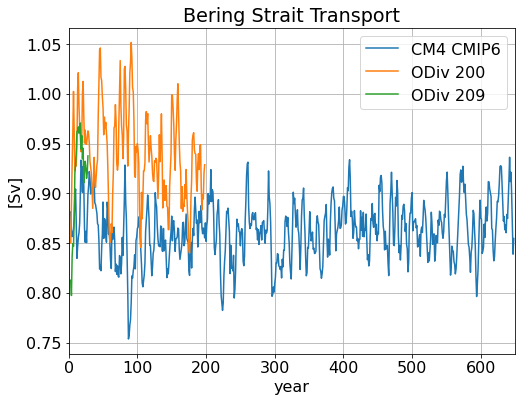

In [21]:
# Volume transport through Bering Strait
fig = plt.figure(figsize=(8,6))
(DS_cmip6pi.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='CM4 CMIP6')
(DS_o200.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 200')
(DS_o209.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 209')
plt.legend()
plt.title('Bering Strait Transport')
plt.ylabel('[Sv]')
plt.xlim(0,650)
plt.grid()
plt.show()

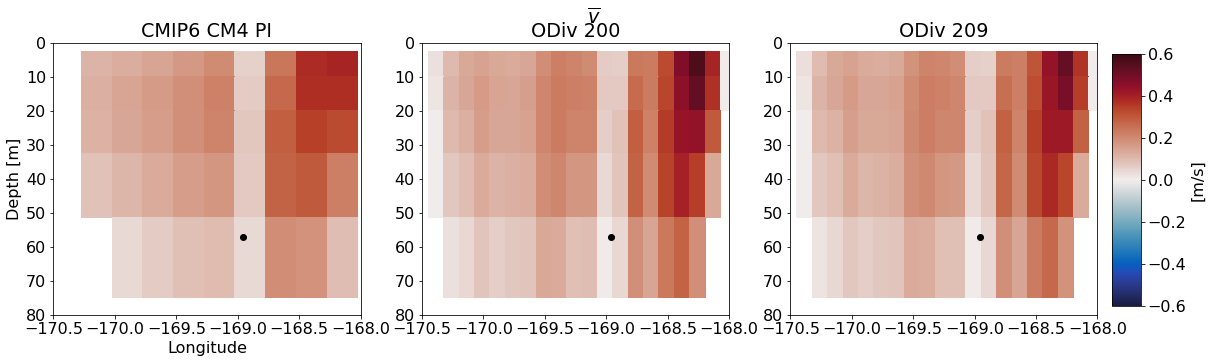

In [24]:
# Cross-sections of mean meridional velocity
vlim = 0.6
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon_v,DS_cmip6pi.z_l,DS_cmip6pi.vo.mean('time'),
               cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# ODiv 200
ax1.pcolormesh(DS_o200.geolon_v,DS_o200.z_l,DS_o200.vo.mean('time'),
               cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('ODiv 200')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon_v,DS_o209.z_l,DS_o209.vo.mean('time'),
                    cmap='cmo.balance',vmin=-vlim,vmax=vlim)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('ODiv 209')

# additional formatting
fig.suptitle('$\overline{v}$')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('[m/s]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_meanXZsection_modelPIObs.pdf')

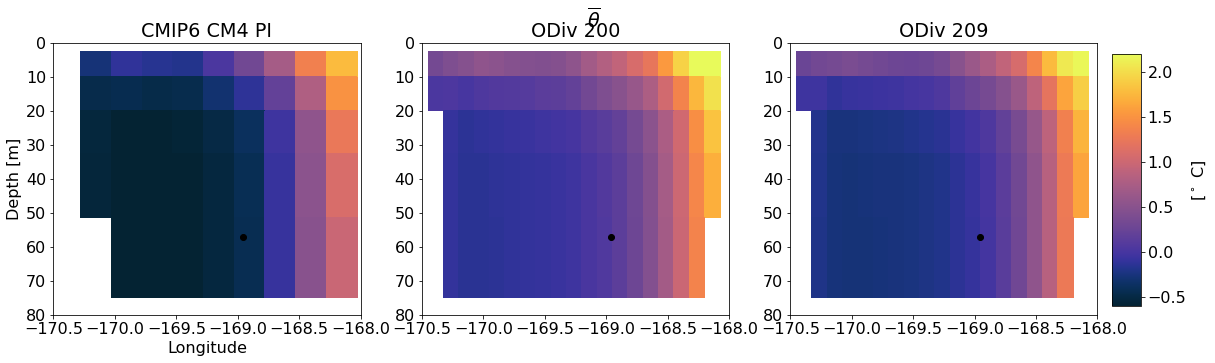

In [25]:
# Cross-sections of mean temperature
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.thetao.mean('time'),
               cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# ODiv 200
ax1.pcolormesh(DS_o200.geolon,DS_o200.z_l,DS_o200.thetao.mean('time'),
               cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('ODiv 200')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.thetao.mean('time'),
                    cmap='cmo.thermal',vmin=-0.6,vmax=2.2)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('ODiv 209')

# additional formatting
fig.suptitle(r'$\overline{\theta}$')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('[$^\circ$ C]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/thetao_meanXZsection_modelPIObs.pdf')

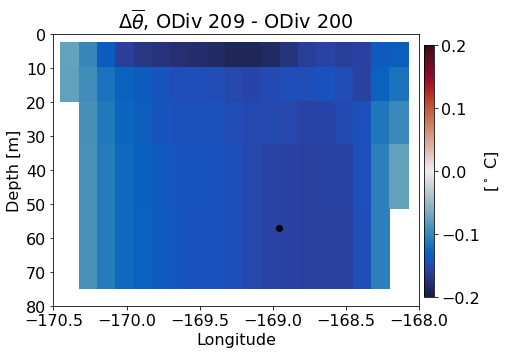

In [80]:
# Difference in Cross-sections of mean temperature for ODiv 209 and 200
fig, (ax0) = plt.subplots(1, 1, figsize=(7,5))
im = ax0.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.thetao.mean('time') - DS_o200.thetao.mean('time'),
                    cmap='cmo.balance',vmin=-0.2,vmax=0.2)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title(r'$\Delta \overline{\theta}$, ODiv 209 - ODiv 200')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('[$^\circ$ C]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/dthetao_meanXZsection_ODiv209ODiv200.pdf')

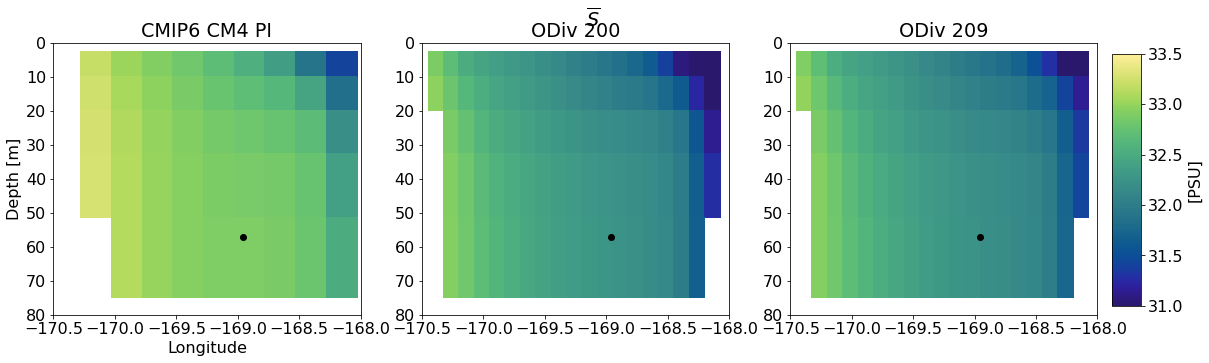

In [26]:
# Cross-sections of mean salinity
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# CMIP6 CM4
ax0.pcolormesh(DS_cmip6pi.geolon,DS_cmip6pi.z_l,DS_cmip6pi.so.mean('time'),
               cmap='cmo.haline',vmin=31,vmax=33.5)
ax0.scatter(llz_moor[1],llz_moor[2],c='k')
ax0.set_ylim(0,80)
ax0.set_xlim(-170.5,-168)
ax0.invert_yaxis()
ax0.set_title('CMIP6 CM4 PI')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Longitude')

# ODiv 200
ax1.pcolormesh(DS_o200.geolon,DS_o200.z_l,DS_o200.so.mean('time'),
               cmap='cmo.haline',vmin=31,vmax=33.5)
ax1.scatter(llz_moor[1],llz_moor[2],c='k')
ax1.set_ylim(0,80)
ax1.set_xlim(-170.5,-168)
ax1.invert_yaxis()
ax1.set_title('ODiv 200')

# Odiv 209
im = ax2.pcolormesh(DS_o209.geolon,DS_o209.z_l,DS_o209.so.mean('time'),
                    cmap='cmo.haline',vmin=31,vmax=33.5)
ax2.scatter(llz_moor[1],llz_moor[2],c='k')
ax2.set_ylim(0,80)
ax2.set_xlim(-170.5,-168)
ax2.invert_yaxis()
ax2.set_title('ODiv 209')

# additional formatting
fig.suptitle('$\overline{S}$')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('[PSU]')
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/so_meanXZsection_modelPIObs.pdf')

## Set observational paths

In [27]:
# Volume transport
fname_T = '../data/BeringStraitMooring/BeringStrait_Annualmeans_TRANSPORT_Jan2021.txt'
# Heat flux
fname_H = '../data/BeringStraitMooring/BeringStrait_Annualmeans_HEAT_Jan2021.txt'
# Freshwater flux
fname_F = '../data/BeringStraitMooring/BeringStrait_Annualmeans_FW_Jan2021.txt'

## Read in observational data

In [28]:
# Volume transport
BST = np.loadtxt(fname_T, comments='%')
# Heat flux
BSH = np.loadtxt(fname_H, comments='%')
# Freshwater flux
BSF = np.loadtxt(fname_F, comments='%')

## Make observational time series

In [29]:
# Make time array
time = xr.cftime_range(start=BST[0,0].astype('int').astype('str'), periods=BST.shape[0], freq="A-JUN", calendar="noleap")

In [30]:
# Volume transport
T_vol  = BST[:,-2] + 0.1
T_volE = BST[:,-1]

In [31]:
# Heat transport
T_heat  = (BSH[:,-2] + BSH[:,-1])/2
T_heatE = BSH[:,5]

In [32]:
# Freshwater transport
T_fresh  = (BSF[:,-2] + BSF[:,-1])/2
T_freshE = BSF[:,5]

## Check the Berring Strait cross-sectional area for each simulation

In [33]:
# CMIP6 CM4
area_cmip6 = (DS_cmip6pi.volcello.sum('z_l')/DS_cmip6pi.dyCv).sum('xh').mean('time').values
# HighRes CM4
area_hres = (DS_o200.volcello.sum('z_l')/DS_o200.dyCv).sum('xh').mean('time').values

In [34]:
print('Bering Strait cross-sectional area [m^3]')
print('Observations: %i' %area_BS)
print('   CMIP6 CM4: %i' %area_cmip6)
print(' HighRes CM4: %i' %area_hres)

Bering Strait cross-sectional area [m^3]
Observations: 4250000
   CMIP6 CM4: 4679149
 HighRes CM4: 4821945


In [35]:
print('Simulated Bering Strait frational cross-sectional area')
print('  CMIP6 CM4: %.3f' %(area_cmip6/area_BS))
print('HighRes CM4: %.3f' %(area_hres/area_BS))

Simulated Bering Strait frational cross-sectional area
  CMIP6 CM4: 1.101
HighRes CM4: 1.135


## Calc full model volume transports [m$^3$/s]

In [36]:
# CMIP6 CM4 pi
DS_cmip6pi['T_vol'] = DS_cmip6pi.vmo/rho_0

In [37]:
# CMIP6 CM4 historical
DS_cmip6hi['T_vol'] = DS_cmip6hi.vmo/rho_0

In [38]:
# ODIV200 CM4
DS_o200['T_vol'] = DS_o200.vmo/rho_0

In [39]:
# ODIV209 CM4
DS_o209['T_vol'] = DS_o209.vmo/rho_0

## Calc model volume transports using the mooring method [m$^3$/s]

In [40]:
# CMIP6 CM4 pi
DS_cmip6pi['T_volM'] = DS_cmip6pi.vo.isel(
    xh=abs(DS_cmip6pi.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) * area_BS + 1e5

In [41]:
# CMIP6 CM4 historical
DS_cmip6hi['T_volM'] = DS_cmip6hi.vo.isel(
    xh=abs(DS_cmip6hi.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) * area_BS + 1e5

In [42]:
# CMIP6 CM4 historical
DS_cmip6hi['T_volMz'] = DS_cmip6hi.vo.sel(z_l=llz_moor[-1],method='nearest').mean('xh').chunk(
    {'time':300000}) * area_BS + 1e5

In [43]:
# ODIV200 CM4
DS_o200['T_volM'] = DS_o200.vo.isel(
    xh=abs(DS_o200.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) * area_BS + 1e5

In [44]:
# ODIV209 CM4
DS_o209['T_volM'] = DS_o209.vo.isel(
    xh=abs(DS_o209.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) * area_BS + 1e5

## Calculate Heat Fluxes [J/s] and Transports [J]

In [45]:
# CMIP6 CM4 pi
DS_cmip6pi['F_heat'] = rho_0 * DS_cmip6pi.T_vol * C_p * (DS_cmip6pi.thetao - theta_ref)
DS_cmip6pi['T_heat'] = DS_cmip6pi.F_heat * 86400

In [46]:
# CMIP6 CM4 historical
DS_cmip6hi['F_heat'] = rho_0 * DS_cmip6hi.T_vol * C_p * (DS_cmip6hi.thetao - theta_ref)
DS_cmip6hi['T_heat'] = DS_cmip6hi.F_heat * 86400

In [47]:
# ODIV200 CM4
DS_o200['F_heat'] = rho_0 * DS_o200.T_vol * C_p * (DS_o200.thetao - theta_ref)
DS_o200['T_heat'] = DS_o200.F_heat * 86400

In [48]:
# ODIV209 CM4
DS_o209['F_heat'] = rho_0 * DS_o209.T_vol * C_p * (DS_o209.thetao - theta_ref)
DS_o209['T_heat'] = DS_o209.F_heat * 86400

## Calculate Heat Fluxes [J/s] and Transports [J] using mooring method

In [49]:
# CMIP6 CM4 pi
DS_cmip6pi['F_heatM'] = rho_0 * DS_cmip6pi.T_volM * C_p * (DS_cmip6pi.thetao.isel(
    xh=abs(DS_cmip6pi.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) - theta_ref)
DS_cmip6pi['T_heatM'] = DS_cmip6pi.F_heatM * 86400

In [50]:
# CMIP6 CM4 historical
DS_cmip6hi['F_heatM'] = rho_0 * DS_cmip6hi.T_volM * C_p * (DS_cmip6hi.thetao.isel(
    xh=abs(DS_cmip6hi.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) - theta_ref)
DS_cmip6hi['T_heatM'] = DS_cmip6hi.F_heatM * 86400

In [51]:
# ODIV200 CM4
DS_o200['F_heatM'] = rho_0 * DS_o200.T_volM * C_p * (DS_o200.thetao.isel(
    xh=abs(DS_o200.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) - theta_ref)
DS_o200['T_heatM'] = DS_o200.F_heatM * 86400

In [52]:
# ODIV209 CM4
DS_o209['F_heatM'] = rho_0 * DS_o209.T_volM * C_p * (DS_o209.thetao.isel(
    xh=abs(DS_o209.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000}) - theta_ref)
DS_o209['T_heatM'] = DS_o209.F_heatM * 86400

## Calculate Freshwater Fluxes [km$^3$/s] and Transports [km$^3$]

In [53]:
# CMIP6 CM4 pi
DS_cmip6pi['F_fresh'] = DS_cmip6pi.T_vol * (1 - (DS_cmip6pi.so/S_ref)) * (10**-9)
DS_cmip6pi['T_fresh'] = DS_cmip6pi.F_fresh * 86400

In [54]:
# CMIP6 CM4 historical
DS_cmip6hi['F_fresh'] = DS_cmip6hi.T_vol * (1 - (DS_cmip6hi.so/S_ref)) * (10**-9)
DS_cmip6hi['T_fresh'] = DS_cmip6hi.F_fresh * 86400

In [55]:
# ODIV200 CM4
DS_o200['F_fresh'] = DS_o200.T_vol * (1 - (DS_o200.so/S_ref)) * (10**-9)
DS_o200['T_fresh'] = DS_o200.F_fresh * 86400

In [56]:
# ODIV209 CM4
DS_o209['F_fresh'] = DS_o209.T_vol * (1 - (DS_o209.so/S_ref)) * (10**-9)
DS_o209['T_fresh'] = DS_o209.F_fresh * 86400

## Calculate Freshwater Fluxes [km$^3$/s] and Transports [km$^3$] using mooring method

In [57]:
# CMIP6 CM4 pi
DS_cmip6pi['F_freshM'] = DS_cmip6pi.T_volM * (1 - (DS_cmip6pi.so.isel(
    xh=abs(DS_cmip6pi.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000})/S_ref)) * (10**-9)
DS_cmip6pi['T_freshM'] = DS_cmip6pi.F_freshM * 86400

In [58]:
# CMIP6 CM4 historical
DS_cmip6hi['F_freshM'] = DS_cmip6hi.T_volM * (1 - (DS_cmip6hi.so.isel(
    xh=abs(DS_cmip6hi.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000})/S_ref)) * (10**-9)
DS_cmip6hi['T_freshM'] = DS_cmip6hi.F_freshM * 86400

In [59]:
# ODIV200 CM4
DS_o200['F_freshM'] = DS_o200.T_volM * (1 - (DS_o200.so.isel(
    xh=abs(DS_o200.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000})/S_ref)) * (10**-9)
DS_o200['T_freshM'] = DS_o200.F_freshM * 86400

In [60]:
# ODIV209 CM4
DS_o209['F_freshM'] = DS_o209.T_volM * (1 - (DS_o209.so.isel(
    xh=abs(DS_o209.geolon_v - llz_moor[1]).argmin()).sel(z_l=llz_moor[-1],method='nearest').chunk(
    {'time':300000})/S_ref)) * (10**-9)
DS_o209['T_freshM'] = DS_o209.F_freshM * 86400

## Plot historical run with observations

In [61]:
# Make model time series
T = (DS_cmip6hi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean()
Tm = (DS_cmip6hi.T_volM*(10**-6)).groupby('time.year').mean()
Tz = (DS_cmip6hi.T_volMz*(10**-6)).groupby('time.year').mean()
H = (DS_cmip6hi.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum()
Hm = (DS_cmip6hi.T_heatM*(10**-20)).groupby('time.year').sum()
F = DS_cmip6hi.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum()
Fm = DS_cmip6hi.T_freshM.groupby('time.year').sum()

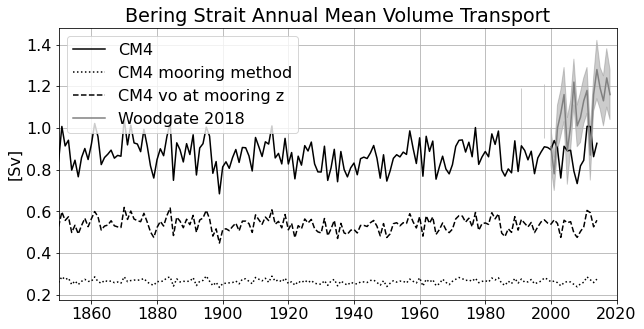

In [62]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(T.year,T,'k',label = 'CM4')
plt.plot(Tm.year,Tm,':k',label = 'CM4 mooring method')
plt.plot(Tz.year,Tz,'--k',label = 'CM4 vo at mooring z')
plt.fill_between(time.year,T_vol-T_volE,T_vol+T_volE,color='grey',alpha=0.4)
plt.plot(time.year,T_vol,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Mean Volume Transport')
plt.ylabel('[Sv]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tvol_annual_modelHistObs.pdf')

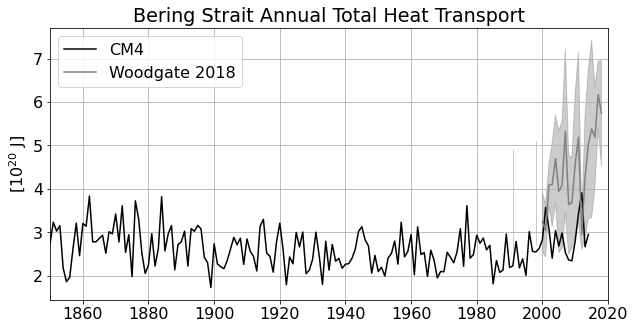

In [63]:
# Heat transport
fig = plt.figure(figsize=(10,5))
plt.plot(H.year,H,'k',label = 'CM4')
plt.fill_between(time.year,T_heat-T_heatE,T_heat+T_heatE,color='grey',alpha=0.4)
plt.plot(time.year,T_heat,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Heat Transport')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Theat_annual_modelHistObs.pdf')

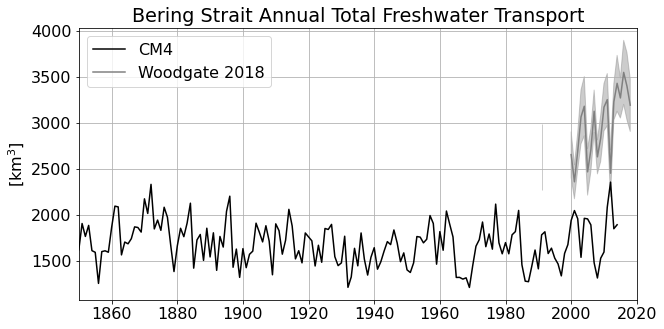

In [64]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
plt.plot(F.year,F,'k',label = 'CM4')
plt.fill_between(time.year,T_fresh-T_freshE,T_fresh+T_freshE,color='grey',alpha=0.4)
plt.plot(time.year,T_fresh,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Freshwater Transport')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper left')
plt.xlim(1850,2020)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tfresh_annual_modelHistObs.pdf')

## Plot PI runs with observation statistics

In [65]:
# Observation stats
# Volume
T_bar = np.nanmean(T_vol)
T_err = np.nanmean(T_volE)
# Heat
H_bar = np.nanmean(T_heat)
H_err = np.nanmean(T_heatE)
# Freshwater
F_bar = np.nanmean(T_fresh)
F_err = np.nanmean(T_freshE)

In [66]:
# Make model volume transport timeseries
T_cm4 = (DS_cmip6pi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
T_o200 = (DS_o200.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
T_o209 = (DS_o209.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()

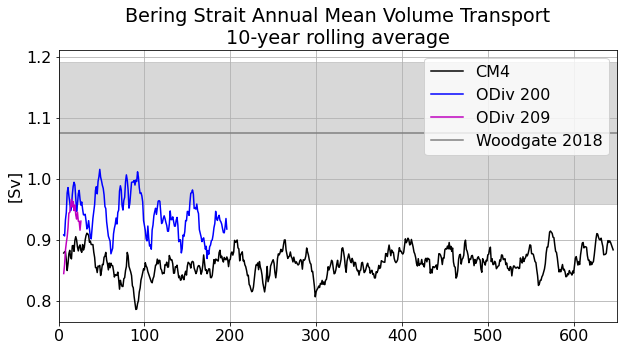

In [67]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(T_cm4.year,T_cm4,'k',label = 'CM4')
# plt.plot(T_cm4M.year,T_cm4M,'m',label = 'CM4 mooring method')
plt.plot(T_o200.year,T_o200,'b',label = 'ODiv 200')
plt.plot(T_o209.year,T_o209,'m',label = 'ODiv 209')
plt.fill_between([0, 650],[T_bar-T_err, T_bar-T_err],[T_bar+T_err, T_bar+T_err],color='grey',alpha=0.3)
plt.plot([0, 650],[T_bar, T_bar],'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Mean Volume Transport\n10-year rolling average')
plt.ylabel('[Sv]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tvol_annual_modelPIObs.pdf')

In [68]:
# Make model heat transport timeseries
H_cm4 = (DS_cmip6pi.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
H_o200 = (DS_o200.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
H_o209 = (DS_o209.T_heat.sum(dim=['z_l','xh'])*(10**-20)).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()

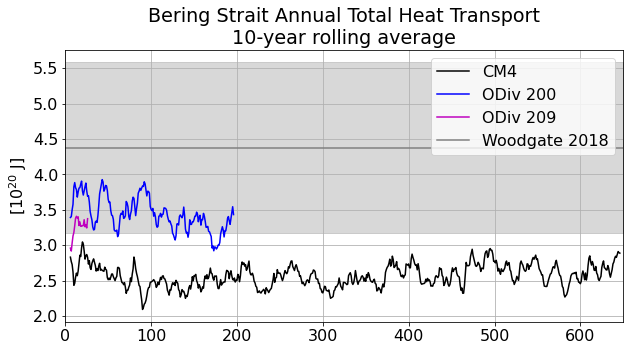

In [69]:
# Heat transport
fig = plt.figure(figsize=(10,5))
plt.plot(H_cm4.year,H_cm4,'k',label = 'CM4')
plt.plot(H_o200.year,H_o200,'b',label = 'ODiv 200')
plt.plot(H_o209.year,H_o209,'m',label = 'ODiv 209')
plt.fill_between([0, 650],[H_bar-H_err, H_bar-H_err],[H_bar+H_err, H_bar+H_err],color='grey',alpha=0.3)
plt.plot([0, 650],[H_bar, H_bar],'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Heat Transport\n10-year rolling average')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Theat_annual_modelPIObs.pdf')

In [70]:
# Make model heat transport timeseries
F_cm4 = DS_cmip6pi.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
F_o200 = DS_o200.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()
F_o209 = DS_o209.T_fresh.sum(dim=['z_l','xh']).groupby('time.year').sum().chunk(
    {'year':1000}).rolling(year=10,center=True).mean()

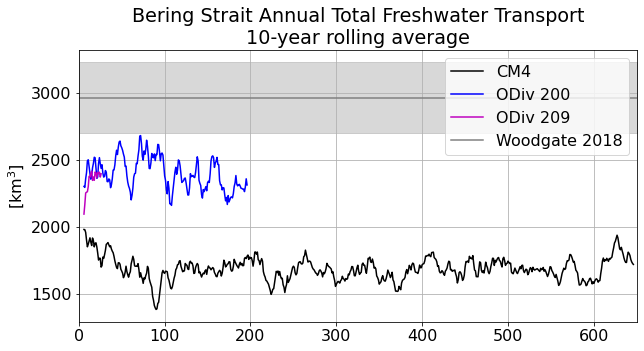

In [71]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
plt.plot(F_cm4.year,F_cm4,'k',label = 'CM4')
plt.plot(F_o200.year,F_o200,'b',label = 'ODiv 200')
plt.plot(F_o209.year,F_o209,'m',label = 'ODiv 209')
plt.fill_between([0, 650],[F_bar-F_err, F_bar-F_err],[F_bar+F_err, F_bar+F_err],color='grey',alpha=0.3)
plt.plot([0, 650],[F_bar, F_bar],'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Annual Total Freshwater Transport\n10-year rolling average')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tfresh_annual_modelPIObs.pdf')